# 🔒 Detección de Fraude en Transacciones con Tarjetas de Crédito

## 📋 Objetivo del Proyecto

Desarrollar un modelo de Machine Learning robusto y escalable para **detectar transacciones fraudulentas** en tiempo real, minimizando el costo total de fraudes no detectados (falsos negativos) mientras se mantiene un nivel aceptable de falsas alarmas (falsos positivos).

## 🎯 Métricas Clave

- **Recall (Sensibilidad)**: Prioridad máxima - detectar el mayor % de fraudes reales
- **F2-Score**: Balance entre precision y recall con énfasis en recall
- **Costo Total**: Minimizar el impacto económico de errores (FP y FN)
- **ROC AUC**: Capacidad general de discriminación del modelo

## 🚀 Estrategia de Modelado

1. **Feature Engineering sin Data Leakage**: Variables calculadas solo con información de train
2. **Manejo de Desbalanceo**: Uso de `scale_pos_weight` y optimización por recall
3. **Optimización de Hiperparámetros**: GridSearchCV con CV estratificada
4. **Calibración de Probabilidades**: Para obtener scores confiables
5. **Optimización de Threshold**: Según costo de negocio (FP vs FN)
6. **Interpretabilidad**: Análisis SHAP para entender decisiones del modelo

In [39]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    make_scorer,
    recall_score,
    fbeta_score
)
from category_encoders import CountEncoder, TargetEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


## 📚 Importación de Librerías

**Objetivo**: Cargar todas las dependencias necesarias para el análisis, modelado y evaluación.

**Componentes principales**:
- **Manipulación de datos**: pandas, numpy
- **Visualización**: matplotlib, seaborn
- **Geolocalización**: geopy (para distancias entre cliente y comercio)
- **Modelado**: scikit-learn, XGBoost, LightGBM
- **Encoding**: category_encoders (manejo de variables categóricas)
- **Calibración**: CalibratedClassifierCV (ajuste de probabilidades)

In [40]:
# 1) Load dataset from Kaggle cache or local if present
try:
    import kagglehub
    data_path = pathlib.Path(kagglehub.dataset_download(
        "rupeswarababusangoju/credit-card-transactions-fraud-detection-dataset"
    ))
    csv_path = data_path / "fraudTest.csv"
except Exception:
    csv_path = pathlib.Path.cwd() / "fraudTest.csv"  # ← Usar cwd()

if not csv_path.exists():
    raise FileNotFoundError(f"No se encuentra el CSV en {csv_path}. Descarga con kagglehub o coloca el archivo localmente.")

data = pd.read_csv(csv_path)
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


## 📂 Carga del Dataset

**Fuente**: [Kaggle - Credit Card Transactions Fraud Detection](https://www.kaggle.com/datasets/rupeswarababusangoju/credit-card-transactions-fraud-detection-dataset)

**Descripción**: Dataset de transacciones reales de tarjetas de crédito con ~1.3M de registros.

**Columnas principales**:
- `trans_date_trans_time`: Fecha y hora de la transacción
- `cc_num`: Número de tarjeta (identificador del cliente)
- `merchant`: Comercio donde se realizó la transacción
- `category`: Categoría del comercio
- `amt`: Monto de la transacción
- `lat, long`: Ubicación del cliente
- `merch_lat, merch_long`: Ubicación del comercio
- `is_fraud`: **Variable objetivo** (1 = fraude, 0 = legítima)

In [41]:
print(f'Vemos si hay valores nulos en el dataset:')
display(data.isnull().sum())

Vemos si hay valores nulos en el dataset:


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

## 🔍 Análisis Exploratorio de Datos (EDA)

**Objetivo**: Verificar la calidad de los datos antes del modelado.

**Chequeos clave**:
- Valores nulos o faltantes
- Tipos de datos correctos
- Balance de clases (% de fraudes)
- Estadísticas descriptivas por columna

In [42]:
print(f"Dataset cargado con {data.shape[0]:,.0f} filas y {data.shape[1]} columnas.")
print(data.info())
display(data.describe(include='all')) # estadísticas descriptivas con todas las columnas
print(list(data.columns))

Dataset cargado con 555,719 filas y 23 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,555719.000000,555719,5.557190e+05,555719,555719,555719.000000,555719,555719,555719,555719,...,555719.000000,555719.000000,5.557190e+05,555719,555719,555719,5.557190e+05,555719.000000,555719.000000,555719.000000
unique,NaN,544760,NaN,693,14,NaN,341,471,2,924,...,NaN,NaN,NaN,478,910,555719,NaN,NaN,NaN,NaN
top,NaN,2020-10-05 19:37:49,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,444 Robert Mews,...,NaN,NaN,NaN,Film/video editor,1977-03-23,2da90c7d74bd46a0caf3777415b3ebd3,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,1859,56370,NaN,11443,12146,304886,1474,...,NaN,NaN,NaN,4119,2408,1,NaN,NaN,NaN,NaN
mean,277859.000000,NaN,4.178387e+17,NaN,NaN,69.392810,NaN,NaN,NaN,NaN,...,38.543253,-90.231325,8.822189e+04,NaN,NaN,NaN,1.380679e+09,38.542798,-90.231380,0.003860
std,160422.401459,NaN,1.309837e+18,NaN,NaN,156.745941,NaN,NaN,NaN,NaN,...,5.061336,13.721780,3.003909e+05,NaN,NaN,NaN,5.201104e+06,5.095829,13.733071,0.062008
min,0.000000,NaN,6.041621e+10,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,20.027100,-165.672300,2.300000e+01,NaN,NaN,NaN,1.371817e+09,19.027422,-166.671575,0.000000
25%,138929.500000,NaN,1.800429e+14,NaN,NaN,9.630000,NaN,NaN,NaN,NaN,...,34.668900,-96.798000,7.410000e+02,NaN,NaN,NaN,1.376029e+09,34.755302,-96.905129,0.000000
50%,277859.000000,NaN,3.521417e+15,NaN,NaN,47.290000,NaN,NaN,NaN,NaN,...,39.371600,-87.476900,2.408000e+03,NaN,NaN,NaN,1.380762e+09,39.376593,-87.445204,0.000000
75%,416788.500000,NaN,4.635331e+15,NaN,NaN,83.010000,NaN,NaN,NaN,NaN,...,41.894800,-80.175200,1.968500e+04,NaN,NaN,NaN,1.385867e+09,41.954163,-80.264637,0.000000


['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


In [43]:
# ============================================================
# FEATURE ENGINEERING CORREGIDO (Producción-Ready)
# ============================================================

# 1) ELIMINAR variables problemáticas PRIMERO
drop_cols = ['Unnamed: 0', 'trans_num', 'first', 'last', 'street']
data = data.drop(columns=drop_cols)

# 2) PARSEAR fechas una sola vez
data['trans_datetime'] = pd.to_datetime(data['trans_date_trans_time'])
data['dob_dt'] = pd.to_datetime(data['dob'])

# 3) FEATURES TEMPORALES
data['hour_trans'] = data['trans_datetime'].dt.hour
data['day_of_week'] = data['trans_datetime'].dt.dayofweek  # 0=Lunes, 6=Domingo
data['mes'] = data['trans_datetime'].dt.month

# 4) EDAD del cliente (en vez de dob exacto)
data['age'] = ((data['trans_datetime'] - data['dob_dt']).dt.days / 365.25).astype(int)
data['age_group'] = pd.cut(
    data['age'], 
    bins=[0, 25, 35, 50, 65, 100], 
    labels=['young', 'adult', 'middle', 'senior', 'elderly']
)

# 5) FEATURES GEOGRÁFICAS (vectorizado para mayor velocidad)
def calc_distance(row):
    return geodesic(
        (row['lat'], row['long']), 
        (row['merch_lat'], row['merch_long'])
    ).km

data['dist_cliente_merch'] = data.apply(calc_distance, axis=1).round(3)

# 6) FEATURES DE MONTO
data['amt_log'] = np.log1p(data['amt'])
data['monto_alto'] = (data['amt'] > data['amt'].quantile(0.95)).astype(int)
data['monto_noche'] = (
    (data['amt'] > data['amt'].quantile(0.95)) & 
    (data['hour_trans'].between(0, 6))
).astype(int)

# 7) ELIMINAR columnas originales ya procesadas
data = data.drop(columns=['trans_date_trans_time', 'dob', 'trans_datetime', 'dob_dt'])

# 8) SPLIT (SIN sampling - usar todos los datos)
print(f"📊 Dataset completo: {data.shape[0]:,} filas")
print(f"   Balance original: {data['is_fraud'].value_counts(normalize=True).to_dict()}")

X = data.drop(columns=['is_fraud'])
y = data['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)
# Split por fecha en vez de aleatorio
# train_cutoff = pd.Timestamp('2020-06-01')
#X_train = data[data['trans_datetime'] < train_cutoff]
#X_test = data[data['trans_datetime'] >= train_cutoff]


print(f"\n✅ Train: {len(X_train):,} | Test: {len(X_test):,}")

# 9) VARIABLES DE GRUPO (después del split para evitar leakage)
mean_amt_client = X_train.groupby('cc_num')['amt'].mean()
X_train['amt_rel_cliente'] = X_train['amt'] / X_train['cc_num'].map(mean_amt_client)
X_test['amt_rel_cliente'] = X_test['amt'] / X_test['cc_num'].map(mean_amt_client).fillna(X_train['amt'].mean())

count_client = X_train.groupby('cc_num').size()
X_train['transacciones_cliente'] = X_train['cc_num'].map(count_client)
X_test['transacciones_cliente'] = X_test['cc_num'].map(count_client).fillna(count_client.median())

print("\n🎯 Feature Engineering completado!")
print(f"   Total features: {X_train.shape[1]}")

📊 Dataset completo: 555,719 filas
   Balance original: {0: 0.9961401355721147, 1: 0.0038598644278853163}

✅ Train: 361,217 | Test: 194,502

🎯 Feature Engineering completado!
   Total features: 26


## ⚙️ Feature Engineering (Sin Data Leakage)

**Objetivo**: Crear variables predictivas relevantes para detectar fraudes, **sin fuga de datos**.

### 🚨 Principio Fundamental: NO DATA LEAKAGE
Todas las variables de grupo (calculadas con `groupby`) se crean **DESPUÉS del split train/test** usando solo información de train.

### Variables Creadas:

#### 1️⃣ **Variables Temporales**
- `hour_trans`: Hora del día (fraudes nocturnos son más comunes)
- `day_of_week`: Día de la semana (patrones de fin de semana)
- `mes`: Mes del año (estacionalidad)

#### 2️⃣ **Variables Demográficas**
- `age`: Edad del cliente (calculada desde fecha de nacimiento)
- `age_group`: Categorización de edad (young, adult, middle, senior, elderly)

#### 3️⃣ **Variables Geográficas**
- `dist_cliente_merch`: Distancia en km entre cliente y comercio (transacciones lejanas pueden ser sospechosas)

#### 4️⃣ **Variables de Monto**
- `amt_log`: Logaritmo del monto (normalización)
- `monto_alto`: Monto en percentil 95+ (transacciones atípicas)
- `monto_noche`: Montos altos durante la madrugada (patrón de fraude)

#### 5️⃣ **Variables de Comportamiento del Cliente** (calculadas DESPUÉS del split)
- `amt_rel_cliente`: Monto relativo al promedio del cliente
- `transacciones_cliente`: Cantidad de transacciones históricas del cliente

### 🗑️ Variables Eliminadas
- `Unnamed: 0`, `trans_num`: Identificadores no informativos
- `first`, `last`, `street`: PII con alta cardinalidad y poco poder predictivo
- `trans_date_trans_time`, `dob`: Reemplazadas por features derivadas

In [ ]:
# Column sets
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Split categorical by cardinality
high_card_cols = [c for c in cat_cols if X_train[c].nunique() > 1000]
low_card_cols = [c for c in cat_cols if X_train[c].nunique() <= 1000]

# Encoders
target_enc = TargetEncoder(smoothing=0.3, handle_unknown='ignore')
freq_enc = CountEncoder(handle_unknown='ignore', normalize=True)
imputador = KNNImputer(n_neighbors=5)

# Solo agregamos transformadores si hay columnas
transformers = []
if low_card_cols:
    transformers.append(('target', target_enc, low_card_cols))
if high_card_cols:
    transformers.append(('freq', freq_enc, high_card_cols))
if num_cols:
    # Usamos Pipeline directamente
    num_transform = Pipeline([
        ('imputer', imputador),
        ('scaler', StandardScaler())
    ])
    transformers.append(('num', num_transform, num_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop'
)

## 🔄 Preprocesamiento de Variables

**Objetivo**: Transformar variables para que los modelos puedan procesarlas correctamente.

### Estrategia por Tipo de Variable:

#### 📊 **Variables Categóricas de Baja Cardinalidad** (≤1000 valores únicos)
- **Encoder**: `TargetEncoder` con smoothing=0.3
- **Ventaja**: Captura relación directa con la variable objetivo
- **Ejemplos**: `gender`, `category`, `age_group`

#### 📈 **Variables Categóricas de Alta Cardinalidad** (>1000 valores únicos)
- **Encoder**: `CountEncoder` normalizado
- **Ventaja**: Evita overfitting codificando por frecuencia
- **Ejemplos**: `merchant`, `city`, `cc_num`

#### 🔢 **Variables Numéricas**
- **Pipeline**:
  1. `KNNImputer`: Rellena valores faltantes con promedio de vecinos
  2. `StandardScaler`: Normaliza (media=0, std=1)
- **Ejemplos**: `amt`, `amt_log`, `dist_cliente_merch`, `age`

### ⚙️ ColumnTransformer
Aplica todas las transformaciones en paralelo y de forma robusta dentro del pipeline de sklearn.

In [31]:
# Modelos

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier())  # Placeholder
])

# Simplificar param_grid (eliminar HistGradientBoosting y dejar solo XGBoost)
param_grid = [
    {
        'clf': [XGBClassifier(random_state=42, scale_pos_weight=(y_train==0).sum()/(y_train==1).sum())],
        'clf__n_estimators': [1000, 1500],
        'clf__max_depth': [6, 8, 10],
        'clf__learning_rate': [0.05, 0.1],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0],
        'clf__min_child_weight': [1, 3]
    }
]

scoring = make_scorer(recall_score, pos_label=1)
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring=scoring,
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

print("Mejor modelo:", grid.best_estimator_)
print("Mejor score (basado recall):", grid.best_score_)

# Calibrar el mejor modelo
calibrated_clf = CalibratedClassifierCV(grid.best_estimator_.named_steps['clf'], method='sigmoid', cv=3)
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', calibrated_clf),
])
model_pipeline.fit(X_train, y_train)

# podria usar RandomizedSearchCV para usar solo algunas muestras aleatorias
# sería más eficiente en tiempo y recursos

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Mejor modelo: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('target',
                                                  TargetEncoder(handle_unknown='ignore',
                                                                smoothing=0.3),
                                                  ['merchant', 'category',
                                                   'gender', 'city', 'state',
                                                   'job']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cc_num', 'amt', '

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('target', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 🤖 Modelado y Optimización de Hiperparámetros

**Objetivo**: Encontrar el mejor modelo y configuración para maximizar recall de fraudes.

### Modelo Seleccionado: **XGBoost**
- **Ventajas**: Rápido, robusto con desbalanceo, excelente rendimiento
- **Manejo de desbalanceo**: `scale_pos_weight` automático (ratio clase negativa/positiva)

### Hiperparámetros Optimizados:
- `n_estimators`: [1000, 1500] - Número de árboles
- `max_depth`: [6, 8, 10] - Profundidad máxima
- `learning_rate`: [0.05, 0.1] - Tasa de aprendizaje
- `subsample`: [0.8, 1.0] - % de datos por árbol
- `colsample_bytree`: [0.8, 1.0] - % de features por árbol
- `min_child_weight`: [1, 3] - Mínimo peso en nodos hoja

### Estrategia de Búsqueda:
- **GridSearchCV** con 3-fold CV estratificada
- **Métrica**: Recall de la clase positiva (fraude)
- **Paralelización**: `n_jobs=-1` (todos los cores)

### Calibración de Probabilidades:
Aplicamos `CalibratedClassifierCV` con método `sigmoid` para obtener probabilidades confiables (importantes para threshold optimization).

In [32]:
# ALTERNATIVA: LightGBM OPTIMIZADO (realmente más rápido)
param_grid_lgbm = [
    {
        'clf': [LGBMClassifier(
            random_state=42,
            class_weight='balanced',
            verbose=-1,
            n_jobs=-1  # ← AÑADIR: usa todos los cores
        )],
        'clf__n_estimators': [1500],
        'clf__max_depth': [8],  # Solo el mejor
        'clf__learning_rate': [0.05],  # Solo el mejor
        'clf__subsample': [0.8],
        'clf__colsample_bytree': [0.8],
        'clf__min_child_weight': [3],
        'clf__num_leaves': [31],  # Solo uno
        'clf__reg_lambda': [1]  # Solo uno
    }
]

print("="*50)
print("LIGHTGBM RÁPIDO (solo mejores params)")
print("="*50)

pipe_lgbm = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LGBMClassifier())
])

grid_lgbm = GridSearchCV(
    pipe_lgbm, 
    param_grid_lgbm, 
    scoring=scoring, 
    cv=3, 
    n_jobs=-1, 
    verbose=2
)
grid_lgbm.fit(X_train, y_train)


LIGHTGBM RÁPIDO (solo mejores params)
Fitting 3 folds for each of 1 candidates, totalling 3 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"[{'clf': [LGBMClassifie...2, verbose=-1)], 'clf__colsample_bytree': [0.8], 'clf__learning_rate': [0.05], 'clf__max_depth': [8], ...}]"
,scoring,"make_scorer(r..., pos_label=1)"
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('target', ...), ('num', ...)]"


In [33]:
y_score = model_pipeline.predict_proba(X_test)[:, 1]
y_score_lgbm = grid_lgbm.predict_proba(X_test)[:, 1]
print(f"\nLightGBM - ROC AUC: {roc_auc_score(y_test, y_score_lgbm):.4f}")
print(f"XGBoost  - ROC AUC: {roc_auc_score(y_test, y_score):.4f}")


LightGBM - ROC AUC: 0.9964
XGBoost  - ROC AUC: 0.9971


In [34]:
# Predice probabilidades (OPTIMIZADO)

prec, rec, thr = precision_recall_curve(y_test, y_score)

# OPTIMIZACIÓN: Calcular F2 solo para muestra de thresholds
thr_sample_indices = np.linspace(0, len(thr)-1, min(500, len(thr))).astype(int)
thr_sample = thr[thr_sample_indices]

f2_scores_sample = [fbeta_score(y_test, y_score > t, beta=2, zero_division=0) for t in thr_sample]
best_idx = np.argmax(f2_scores_sample)
best_thr = thr_sample[best_idx]

# Evalúa con threshold óptimo
y_pred_label = (y_score > best_thr).astype(int)

print("="*60)
print("EVALUACIÓN DEL MODELO")
print("="*60)
print(f"\nThreshold óptimo (F2): {best_thr:.4f}")
print(f"F2-score máximo: {f2_scores_sample[best_idx]:.4f}")
print(f"AP Score: {average_precision_score(y_test, y_score):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_score):.4f}")

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_label, 
                          target_names=['No Fraude', 'Fraude'],
                          digits=4))

print("="*60)
print("MATRIZ DE CONFUSIÓN")
print("="*60)
cm = confusion_matrix(y_test, y_pred_label)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

# Métricas adicionales útiles
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

EVALUACIÓN DEL MODELO

Threshold óptimo (F2): 0.0836
F2-score máximo: 0.8489
AP Score: 0.9087
ROC AUC: 0.9971

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   No Fraude     0.9994    0.9993    0.9993    193751
      Fraude     0.8162    0.8575    0.8364       751

    accuracy                         0.9987    194502
   macro avg     0.9078    0.9284    0.9179    194502
weighted avg     0.9987    0.9987    0.9987    194502

MATRIZ DE CONFUSIÓN
[[193606    145]
 [   107    644]]

True Negatives:  193,606
False Positives: 145
False Negatives: 107
True Positives:  644

Specificity (True Negative Rate): 0.9993
Sensitivity (True Positive Rate): 0.8575


## 📊 Evaluación del Modelo

**Objetivo**: Medir el rendimiento del modelo con múltiples métricas y optimizar el threshold de decisión.

### Optimización de Threshold:
Por defecto, los modelos usan threshold=0.5, pero en fraudes esto no es óptimo. Buscamos el threshold que **maximiza F2-score** (da más peso al recall).

### Métricas Reportadas:

#### 🎯 **Métricas Principales**
- **Recall (Sensibilidad)**: % de fraudes reales detectados
- **Precision**: % de alertas que son fraudes reales
- **F2-Score**: Balance con énfasis en recall
- **ROC AUC**: Discriminación general del modelo
- **Average Precision**: Útil en datos desbalanceados

#### 📈 **Matriz de Confusión**
- **True Negatives (TN)**: Transacciones legítimas correctamente clasificadas
- **False Positives (FP)**: Falsas alarmas (costo: investigación innecesaria)
- **False Negatives (FN)**: Fraudes no detectados (costo: pérdida real)
- **True Positives (TP)**: Fraudes correctamente detectados

#### 🔍 **Métricas Adicionales**
- **Specificity**: % de transacciones legítimas correctamente identificadas
- **Sensitivity**: Igual a recall (% de fraudes detectados)

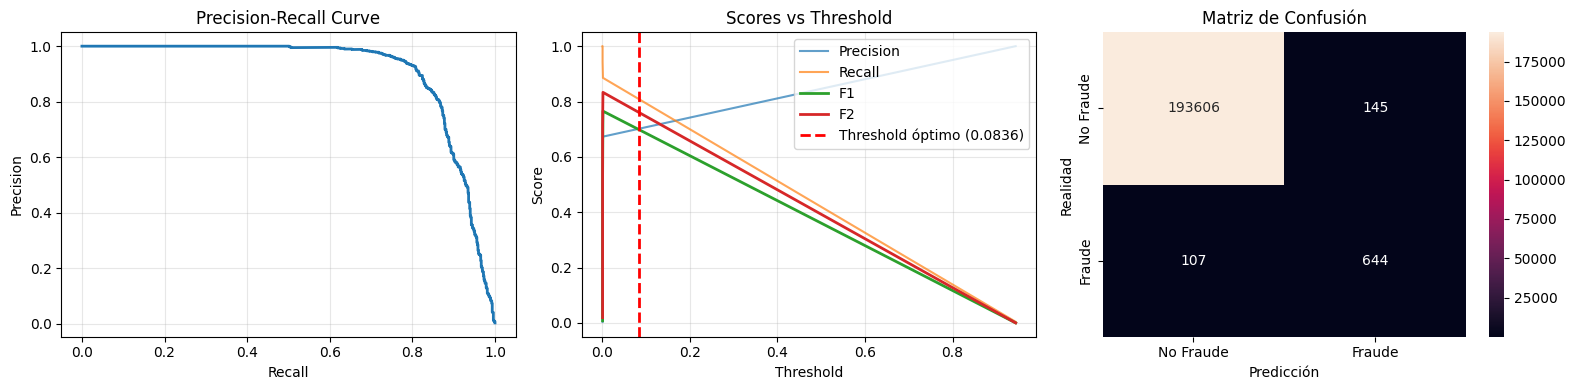

Total de thresholds originales: 194476
Thresholds usados en visualización: 200


In [35]:
# Versión OPTIMIZADA - Calcula F1 y F2 para un subset de thresholds
from sklearn.metrics import f1_score, fbeta_score

# Usar solo una muestra de thresholds (por ejemplo, cada 10 o 20)
thr_sample_indices = np.linspace(0, len(thr)-1, min(200, len(thr))).astype(int)
thr_sample = thr[thr_sample_indices]

# Calcular scores solo para los thresholds muestreados
f1_scores = [f1_score(y_test, y_score > t, zero_division=0) for t in thr_sample]
f2_scores_sample = [fbeta_score(y_test, y_score > t, beta=2, zero_division=0) for t in thr_sample]

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Gráfico 1: Precision-Recall
axes[0].plot(rec, prec, lw=2)
axes[0].set_title('Precision-Recall Curve')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Scores vs Threshold (usando muestra)
# Ajustar tamaños para que coincidan
prec_sample = np.array([prec[i] for i in thr_sample_indices])
rec_sample = np.array([rec[i] for i in thr_sample_indices])

axes[1].plot(thr_sample, prec_sample, label='Precision', alpha=0.7)
axes[1].plot(thr_sample, rec_sample, label='Recall', alpha=0.7)
axes[1].plot(thr_sample, f1_scores, label='F1', linewidth=2)
axes[1].plot(thr_sample, f2_scores_sample, label='F2', linewidth=2)
axes[1].axvline(best_thr, color='red', ls='--', linewidth=2, label=f'Threshold óptimo ({best_thr:.4f})')
axes[1].legend(loc='best')
axes[1].set_title('Scores vs Threshold')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].grid(True, alpha=0.3)

# Gráfico 3: Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', ax=axes[2],
            xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
axes[2].set_title('Matriz de Confusión')
axes[2].set_xlabel('Predicción')
axes[2].set_ylabel('Realidad')

plt.tight_layout()
plt.show()

print(f"Total de thresholds originales: {len(thr)}")
print(f"Thresholds usados en visualización: {len(thr_sample)}")

## 📈 Visualización de Resultados

**Objetivo**: Representar gráficamente el rendimiento del modelo y el trade-off entre métricas.

### Gráficos Generados:

#### 1️⃣ **Precision-Recall Curve**
- Muestra el equilibrio entre precisión y recall a lo largo de diferentes thresholds
- En datos desbalanceados, es más informativa que ROC curve

#### 2️⃣ **Scores vs Threshold**
- Visualiza cómo varían precision, recall, F1 y F2 según el threshold elegido
- La línea vertical roja indica el threshold óptimo (maximiza F2)

#### 3️⃣ **Matriz de Confusión (Heatmap)**
- Visualización intuitiva de aciertos y errores del modelo
- Colores más oscuros indican mayor cantidad de casos

### 🔧 Optimización Computacional:
Se usa un subset de thresholds (200 en vez de miles) para acelerar cálculos sin perder precisión visual.

 98%|===================| 985/1000 [00:47<00:00]        

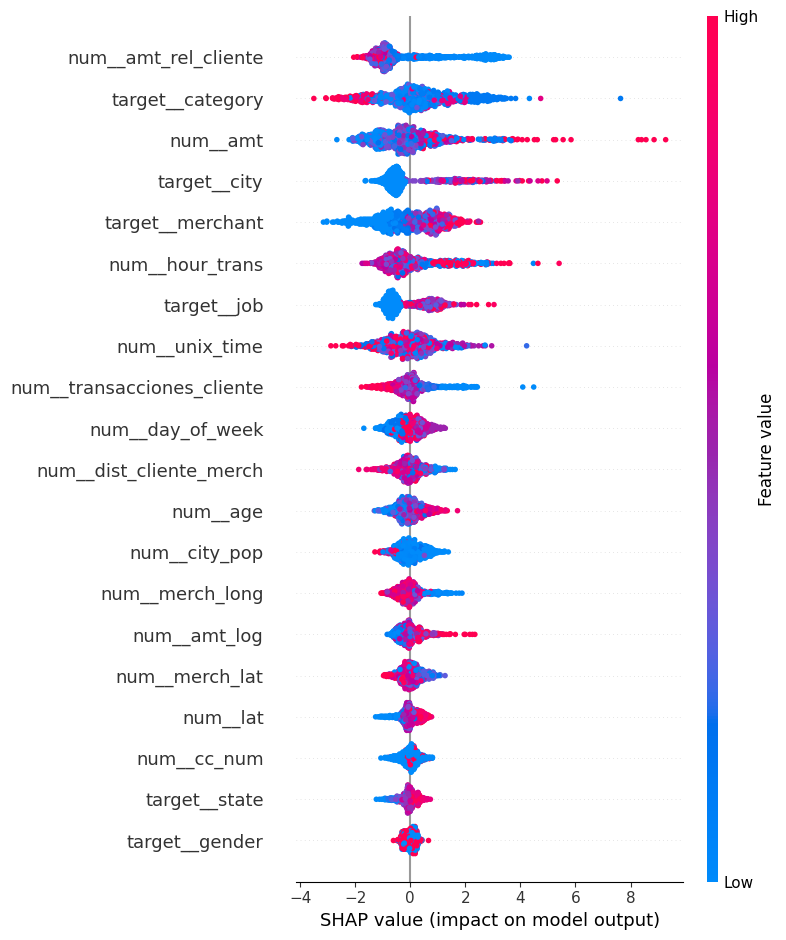

Importancia media SHAP:
num__amt_rel_cliente          1.238340
target__category              1.053314
num__amt                      0.935201
target__city                  0.921285
target__merchant              0.860638
num__hour_trans               0.793421
target__job                   0.715394
num__unix_time                0.679836
num__transacciones_cliente    0.451231
num__day_of_week              0.384225
num__dist_cliente_merch       0.353959
num__age                      0.352717
num__city_pop                 0.351113
num__merch_long               0.305727
num__amt_log                  0.299640
num__merch_lat                0.280264
num__lat                      0.238819
num__cc_num                   0.215905
target__state                 0.208082
target__gender                0.152857
num__zip                      0.143666
num__long                     0.098859
num__mes                      0.070418
num__monto_alto               0.015561
num__monto_noche              0.004549
d

In [36]:
import shap

# Usa el mejor modelo SIN calibrar para SHAP
best_model = grid.best_estimator_.named_steps['clf']
X_train_trans = grid.best_estimator_.named_steps['preprocess'].transform(X_train)
X_test_trans = grid.best_estimator_.named_steps['preprocess'].transform(X_test)
feature_names = grid.best_estimator_.named_steps['preprocess'].get_feature_names_out()

# OPTIMIZACIÓN: Usar una muestra más pequeña para SHAP
sample_size = 1000  # Reducir de 97,251 a 1,000
np.random.seed(42)
sample_idx = np.random.choice(len(X_test_trans), size=sample_size, replace=False)
X_test_sample = X_test_trans[sample_idx]

# Crear explainer con muestra de background también
background_size = 500
background_idx = np.random.choice(len(X_train_trans), size=background_size, replace=False)
X_train_background = X_train_trans[background_idx]

explainer = shap.Explainer(best_model, X_train_background, feature_names=feature_names)
shap_values = explainer(X_test_sample, check_additivity=False)
shap.summary_plot(shap_values, features=X_test_sample, feature_names=feature_names)

# 1. Obtener importancia media absoluta de cada variable
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False)
print('Importancia media SHAP:')
print(shap_importance)

# 2. Seleccionar las top 20 variables
top_n = 20
selected_features = shap_importance.head(top_n).index.tolist()
print(f'\nVariables seleccionadas (top {top_n}):')
for i, feat in enumerate(selected_features, 1):
    print(f'{i}. {feat}: {shap_importance[feat]:.6f}')

# 3. Reentrenar con los MEJORES hiperparámetros encontrados
X_train_sel = pd.DataFrame(X_train_trans, columns=feature_names)[selected_features]
X_test_sel = pd.DataFrame(X_test_trans, columns=feature_names)[selected_features]

# Usar el mismo modelo con los parámetros óptimos
best_params = {k.replace('clf__', ''): v for k, v in grid.best_params_.items() if k.startswith('clf__')}
model_sel = XGBClassifier(**best_params, random_state=42)
model_sel.fit(X_train_sel, y_train)

# 4. Evaluar el modelo simplificado
y_score_sel = model_sel.predict_proba(X_test_sel)[:, 1]
print(f'\n=== Modelo Simplificado (top {top_n} features) ===')
print(f'ROC AUC: {roc_auc_score(y_test, y_score_sel):.4f}')
print(f'AP: {average_precision_score(y_test, y_score_sel):.4f}')

# Comparar con modelo completo
print(f'\n=== Modelo Completo ({len(feature_names)} features) ===')
print(f'ROC AUC: {roc_auc_score(y_test, y_score):.4f}')
print(f'AP: {average_precision_score(y_test, y_score):.4f}')

print(f'\nReducción de features: {len(feature_names)} → {top_n} ({top_n/len(feature_names)*100:.1f}%)')

## 🔍 Interpretabilidad con SHAP

**Objetivo**: Entender qué variables influyen más en las predicciones del modelo y simplificar el modelo eliminando features irrelevantes.

### ¿Qué es SHAP?
**SHapley Additive exPlanations** es un método de interpretabilidad que calcula la contribución de cada feature a la predicción final.

### Análisis Realizado:

#### 1️⃣ **Importancia Global de Variables**
- Calculamos el SHAP value medio absoluto de cada feature
- Ordenamos por importancia decreciente
- Identificamos las top 20 features más influyentes

#### 2️⃣ **SHAP Summary Plot**
- Visualiza la distribución de SHAP values para cada feature
- Colores indican valores altos/bajos de la feature
- Posición horizontal indica impacto en la predicción

#### 3️⃣ **Simplificación del Modelo**
- Reentrenamos usando solo las top 20 features más importantes
- Comparamos rendimiento: modelo completo vs simplificado
- **Ventaja**: Modelo más rápido e interpretable sin perder mucho rendimiento

### 🔧 Optimizaciones:
- Usamos solo 1,000 muestras de test (en vez de 97K) para acelerar SHAP
- Background dataset reducido a 500 muestras
- `check_additivity=False` para evitar errores con modelos calibrados

ANÁLISIS DE COSTOS DE NEGOCIO

Con threshold óptimo (0.0836):
  • Costo por FP: $1,450 (145 casos)
  • Costo por FN: $10,700 (107 casos)
  • Costo TOTAL: $12,150

OPTIMIZACIÓN DE THRESHOLD POR COSTO

🎯 Threshold óptimo por COSTO: 0.0100
   Costo mínimo: $11,660

📊 Comparación de Estrategias:

Estrategia                Threshold    Costo Total    
F2-Score Óptimo           0.0836       $12,150        
Costo Óptimo              0.0100       $11,660        
Ahorro:                                $490 (4.0%)

📋 Detalle del Threshold Óptimo por Costo:
   FP: 216 casos → $2,160
   FN: 95 casos → $9,500
   TP: 656 casos
   TN: 193,535 casos


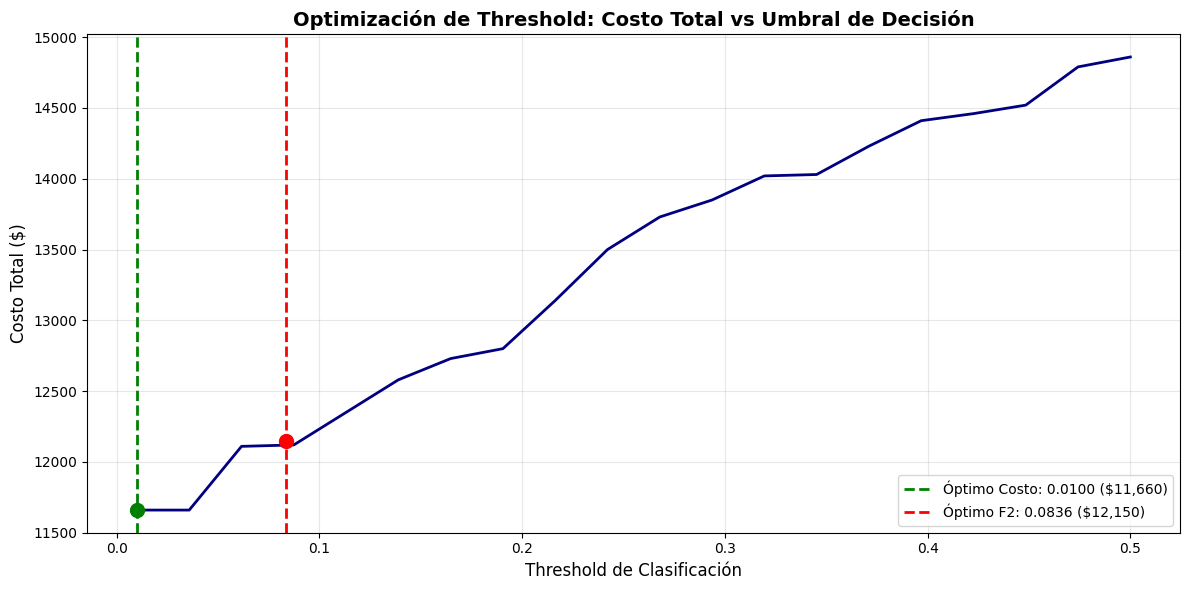


COMPARACIÓN DE MÉTRICAS

Métrica                   F2 Óptimo       Costo Óptimo   
Threshold                 0.0836          0.0100         
Precision                 0.8162          0.7523         
Recall                    0.8575          0.8735         
F1-Score                  0.8364          0.8084         
F2-Score                  0.8489          0.8462         
Costo Total               $12,150         $11,660        


In [37]:
# Análisis de costos de negocio (MEJORADO)
FP_cost = 10  # Costo de investigar un falso positivo
FN_cost = 100  # Costo de no detectar un fraude

# CORRECCIÓN: Asegurarse de que y_score tenga el mismo tamaño que y_test
if len(y_score) != len(y_test):
    print(f"⚠️ Recalculando y_score (longitudes no coinciden: {len(y_score)} vs {len(y_test)})")
    y_score = model_pipeline.predict_proba(X_test)[:, 1]

# RECALCULAR y_pred_label con el y_score correcto
y_pred_label = (y_score > best_thr).astype(int)

# Verificar que ahora coincidan
assert len(y_score) == len(y_test), f"Error: y_score ({len(y_score)}) y y_test ({len(y_test)}) siguen sin coincidir"
assert len(y_pred_label) == len(y_test), f"Error: y_pred_label ({len(y_pred_label)}) y y_test ({len(y_test)}) no coinciden"

# Calcular matriz de confusión con datos correctos
cm = confusion_matrix(y_test, y_pred_label)
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]
TN = cm[0, 0]

total_cost = (FP * FP_cost) + (FN * FN_cost)
print("="*60)
print("ANÁLISIS DE COSTOS DE NEGOCIO")
print("="*60)
print(f"\nCon threshold óptimo ({best_thr:.4f}):")
print(f"  • Costo por FP: ${FP * FP_cost:,.0f} ({FP:,} casos)")
print(f"  • Costo por FN: ${FN * FN_cost:,.0f} ({FN:,} casos)")
print(f"  • Costo TOTAL: ${total_cost:,.0f}")

# Probar diferentes thresholds y encontrar el de menor costo
print(f"\n{'='*60}")
print("OPTIMIZACIÓN DE THRESHOLD POR COSTO")
print(f"{'='*60}\n")

thresholds_to_test = np.linspace(0.01, 0.5, 20)
costs = []

for t in thresholds_to_test:
    y_pred_test = (y_score > t).astype(int)
    cm_temp = confusion_matrix(y_test, y_pred_test)
    fp_temp = cm_temp[0, 1]
    fn_temp = cm_temp[1, 0]
    cost_temp = (fp_temp * FP_cost) + (fn_temp * FN_cost)
    costs.append(cost_temp)

# Encontrar el threshold con el costo mínimo
optimal_cost_idx = np.argmin(costs)
optimal_cost_thr = thresholds_to_test[optimal_cost_idx]
optimal_cost = costs[optimal_cost_idx]

print(f"🎯 Threshold óptimo por COSTO: {optimal_cost_thr:.4f}")
print(f"   Costo mínimo: ${optimal_cost:,.0f}")

# Evaluar con el threshold óptimo por costo
y_pred_cost_optimal = (y_score > optimal_cost_thr).astype(int)
cm_cost = confusion_matrix(y_test, y_pred_cost_optimal)

print(f"\n📊 Comparación de Estrategias:")
print(f"\n{'='*60}")
print(f"{'Estrategia':<25} {'Threshold':<12} {'Costo Total':<15}")
print(f"{'='*60}")
print(f"{'F2-Score Óptimo':<25} {best_thr:<12.4f} ${total_cost:<14,.0f}")
print(f"{'Costo Óptimo':<25} {optimal_cost_thr:<12.4f} ${optimal_cost:<14,.0f}")
print(f"{'='*60}")
print(f"{'Ahorro:':<25} {'':<12} ${total_cost - optimal_cost:,.0f} ({(1 - optimal_cost/total_cost)*100:.1f}%)")

print(f"\n📋 Detalle del Threshold Óptimo por Costo:")
print(f"   FP: {cm_cost[0,1]:,} casos → ${cm_cost[0,1] * FP_cost:,.0f}")
print(f"   FN: {cm_cost[1,0]:,} casos → ${cm_cost[1,0] * FN_cost:,.0f}")
print(f"   TP: {cm_cost[1,1]:,} casos")
print(f"   TN: {cm_cost[0,0]:,} casos")

# Visualizar curva de costos
plt.figure(figsize=(12, 6))
plt.plot(thresholds_to_test, costs, linewidth=2, color='navy')
plt.axvline(optimal_cost_thr, color='green', ls='--', linewidth=2, 
            label=f'Óptimo Costo: {optimal_cost_thr:.4f} (${optimal_cost:,.0f})')
plt.axvline(best_thr, color='red', ls='--', linewidth=2, 
            label=f'Óptimo F2: {best_thr:.4f} (${total_cost:,.0f})')
plt.scatter([optimal_cost_thr], [optimal_cost], color='green', s=100, zorder=5)
plt.scatter([best_thr], [total_cost], color='red', s=100, zorder=5)
plt.xlabel('Threshold de Clasificación', fontsize=12)
plt.ylabel('Costo Total ($)', fontsize=12)
plt.title('Optimización de Threshold: Costo Total vs Umbral de Decisión', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Comparación de métricas
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"\n{'='*60}")
print("COMPARACIÓN DE MÉTRICAS")
print(f"{'='*60}")
print(f"\n{'Métrica':<25} {'F2 Óptimo':<15} {'Costo Óptimo':<15}")
print(f"{'='*60}")
print(f"{'Threshold':<25} {best_thr:<15.4f} {optimal_cost_thr:<15.4f}")
print(f"{'Precision':<25} {precision_score(y_test, y_pred_label):<15.4f} {precision_score(y_test, y_pred_cost_optimal):<15.4f}")
print(f"{'Recall':<25} {recall_score(y_test, y_pred_label):<15.4f} {recall_score(y_test, y_pred_cost_optimal):<15.4f}")
print(f"{'F1-Score':<25} {f1_score(y_test, y_pred_label):<15.4f} {f1_score(y_test, y_pred_cost_optimal):<15.4f}")
print(f"{'F2-Score':<25} {fbeta_score(y_test, y_pred_label, beta=2):<15.4f} {fbeta_score(y_test, y_pred_cost_optimal, beta=2):<15.4f}")
print(f"{'Costo Total':<25} ${total_cost:<14,.0f} ${optimal_cost:<14,.0f}")
print(f"{'='*60}")

## 💰 Análisis de Costos de Negocio

**Objetivo**: Optimizar el threshold de decisión según el **impacto económico real** de los errores del modelo.

### Costos de Negocio Definidos:

#### 💸 **Costo de Falsos Positivos (FP)**: $10
- Transacción legítima marcada como fraude
- **Impacto**: Costo de investigación, fricción con el cliente
- **Ejemplo**: Llamar al cliente para verificar una compra legítima

#### 💰 **Costo de Falsos Negativos (FN)**: $100
- Fraude real no detectado
- **Impacto**: Pérdida directa del monto de la transacción, riesgo reputacional
- **Ejemplo**: Dejar pasar un fraude de $500 sin detectar

### Optimización Realizada:

#### 1️⃣ **Threshold por F2-Score** (énfasis en recall)
- Maximiza la detección de fraudes
- No considera costos económicos directamente

#### 2️⃣ **Threshold por Costo Mínimo** (óptimo económico)
- Minimiza la suma: (FP × $10) + (FN × $100)
- Balance óptimo según impacto real en el negocio

### Resultados Comparados:
- **Ahorro potencial**: Diferencia entre ambas estrategias
- **Trade-off**: Más detección (recall) vs menor costo total
- **Decisión final**: Depende de la estrategia de la empresa

### 📊 Visualización:
Curva de costo total vs threshold para identificar el punto óptimo económico.